# MSDS 7331 Mini - Project 1  

## SVM and Logistic Modeling

Professor: Dr. Jake Drew  
Team: Steven Hayden, Josephine MacDaniel, Korey MacVittie, Afreen Siddiqui, Eduardo Cantu

## Models

In [224]:
#load Libraries
import pandas as pd
import numpy as np
import seaborn as seaborn
import matplotlib.pyplot as plt
import matplotlib as mp1
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [225]:
#Load Data
Accident_df_2016 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2016.csv',low_memory=False)
Accident_df_2015 = pd.read_csv('https://raw.githubusercontent.com/ecantu75/DataMining_Lab1/master/Data/accident_2015.csv',low_memory=False)
Accident_df = pd.concat([Accident_df_2015,Accident_df_2016])

### Data Cleaning

In [226]:
# Displays the record count of non-null Values per attribute and their data type. 
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66978 entries, 0 to 34438
Data columns (total 71 columns):
Unnamed: 0                                                     66978 non-null int64
state_number                                                   66978 non-null int64
state_name                                                     66978 non-null object
consecutive_number                                             66978 non-null int64
number_of_vehicle_forms_submitted_all                          66978 non-null int64
number_of_motor_vehicles_in_transport_mvit                     66978 non-null int64
number_of_parked_working_vehicles                              66978 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    66978 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      66978 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          66978 non-null int64
number_of_forms_submitted_for_persons_in_motor_veh

In [227]:

#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()


2

In [228]:
#Drop duplicate records and keeps the most recent record. We assume the most resent is the most accurate 
Accident_df = Accident_df.drop_duplicates(['consecutive_number'],keep = 'last')

#check for duplicate records. It displays the maximum count of a duplicated record. 
#Any value greater than 1 would mean that the data has duplicates
Accident_df['consecutive_number'].value_counts().max()

1

There are many accidents with missing data regarding the crash time and the arrival time of responders. This information is need for the dependent variable and in turn is crucial for our analysis. That is why it was decided to drop these records with missing data instead of filling the gaps with the mean.  The amount records dropped is about a third of the original data set. 

In [229]:
#Remove any recoreds without  time informaiton for arival and crash time
count_no_rec= Accident_df[(Accident_df['hour_of_crash']>24) | (Accident_df['hour_of_arrival_at_scene']>24)]
Accident_df = Accident_df[(Accident_df['hour_of_crash']<=24) & (Accident_df['hour_of_arrival_at_scene']<=24)]
print(count_no_rec.consecutive_number.count(), 'records were removed due to missing time data.') 


19149 records were removed due to missing time data.


In [230]:
# Add a new Feature. This is the ratio between the number of fatalities and the people involved in the accident.
Accident_df['Fatalities_ratio'] = Accident_df.number_of_fatalities/(Accident_df.number_of_persons_not_in_motor_vehicles_in_transport_mvit + Accident_df.number_of_persons_in_motor_vehicles_in_transport_mvit)

#Converts hour and min to datetime type
#crash
Accident_df.hour_of_crash = pd.to_timedelta(Accident_df.hour_of_crash,unit ='h')
Accident_df.minute_of_crash= pd.to_timedelta(Accident_df.minute_of_crash,unit ='m')
#arrival
Accident_df.hour_of_arrival_at_scene = pd.to_timedelta(Accident_df.hour_of_arrival_at_scene,unit ='h')
Accident_df.minute_of_arrival_at_scene = pd.to_timedelta(Accident_df.minute_of_arrival_at_scene,unit ='m')

#concatenates Hour and Minutes together 
Accident_df['Crash_Time'] = Accident_df['hour_of_crash'] + Accident_df['minute_of_crash'] 
Accident_df['Arrival_Time'] = Accident_df['hour_of_arrival_at_scene'] + Accident_df['minute_of_arrival_at_scene']
#creates a response_time variable from the two fields above and converts to min
Accident_df['Response_Time'] = Accident_df['Arrival_Time'] - Accident_df['Crash_Time']
total_response_time_in_min = pd.DatetimeIndex(Accident_df['Response_Time'])
Accident_df['Response_Time']= total_response_time_in_min.hour * 60 + total_response_time_in_min.minute


#gut check of calculation 
Accident_df[['hour_of_crash','minute_of_crash','Crash_Time','hour_of_arrival_at_scene','minute_of_arrival_at_scene','Arrival_Time','Response_Time']].head()

,hour_of_crash,minute_of_crash,Crash_Time,hour_of_arrival_at_scene,minute_of_arrival_at_scene,Arrival_Time,Response_Time
196,20:00:00,00:47:00,20:47:00,21:00:00,00:01:00,21:01:00,14
240,19:00:00,00:10:00,19:10:00,19:00:00,00:24:00,19:24:00,14
274,14:00:00,00:18:00,14:18:00,14:00:00,00:25:00,14:25:00,7
312,23:00:00,00:23:00,23:23:00,23:00:00,00:29:00,23:29:00,6
959,16:00:00,00:01:00,16:01:00,16:00:00,00:12:00,16:12:00,11


The National Fire Protection Association's (NFPA) has established standard for response time and procedures for Emergency Medical Service (EMS) to adhere to. 

From EMSword.com "The NFPA 1710 standard is based upon a combination of accepted practices and more than 30 years of study, research, testing and validation. Members of the 1710 committee that developed the standard include representatives from various fire agencies and the International Association of City/County Managers (ICMA)."

The NFPA 1710 standard allows for a one-minute call evaluation and preparation, four minutes for the arrival of a unit with first responder. For a situation that requires an advanced life support equipment like an ambulance, their standard is 8 minutes after the call preparation.  

We chose to use their standards as threshold to determine if the paramedics got to the scene of the accident in time. This would be a binary response 0, for not arriving within 9 minutes of the accident and 1 for being within the 9 minutes. 
Source: https://www.emsworld.com/article/10324786/ems-response-time-standards



In [231]:
#creates the binary variable 'within 9 minutes NFPA standard'
Accident_df['within 9 minutes NFPA standard'] = np.where(Accident_df['Response_Time']<=9,1,0)
#Accident_df[['Response_Time','within 9 minutes NFPA standard']].head(10) # Verify the binary variable

Since the logistic regresion will predict if the paramedic got on time to the scene of the accident we would select the attributes that we think affect this variable.

First we would check what columns are available.

In [232]:
#Displays all the available attributes on the dataset
Accident_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16230 entries, 196 to 34438
Data columns (total 76 columns):
Unnamed: 0                                                     16230 non-null int64
state_number                                                   16230 non-null int64
state_name                                                     16230 non-null object
consecutive_number                                             16230 non-null int64
number_of_vehicle_forms_submitted_all                          16230 non-null int64
number_of_motor_vehicles_in_transport_mvit                     16230 non-null int64
number_of_parked_working_vehicles                              16230 non-null int64
number_of_forms_submitted_for_persons_not_in_motor_vehicles    16230 non-null int64
number_of_persons_not_in_motor_vehicles_in_transport_mvit      16230 non-null int64
number_of_persons_in_motor_vehicles_in_transport_mvit          16230 non-null int64
number_of_forms_submitted_for_persons_in_motor_v

From all the attributes in the dataset we would only select a subset to predict the if the paramedics will arrive on time or not.  
* **state_name:** This attribute can give us an indication if there are states that would have a better response time in an accident than others.
* **route_signing_name:** This can give us an insigth on the type of roads where the paramedics find more challenging to get.  
* **light_condition_name:** We want to underdstand how much the lightning coditions affect the ability of the paramedics to get on time to the scene of the accident.  
* **atmospheric_conditions_name:** Adding this attribute, we want to see how the weather conditions affect the reaction time of the paramedics.  
* **within 9 minutes NFPA standard:**  This is our response variable, where 1 means that the paramedics get on time to the scene of the accident. As mentioned before, this threshold is set by the NFPA and is 9 minutes. This field will be 0 if the paramedics take more than 9 minutes to get the the accident.

In [233]:
#Make a copy of the original Data
Accident_forLr=Accident_df.copy()

# 1. Remove attributes that just arent useful for us
for col in ['Unnamed: 0',
             'state_number',
             'consecutive_number',
             'county',
             'city',
             'day_of_crash',
             'month_of_crash',
             'year_of_crash',
             'day_of_week',
             'hour_of_crash',
             'minute_of_crash',
             'national_highway_system',
             'land_use',
             'land_use_name',
             'functional_system',
             'functional_system_name',
             'ownership',
             'ownership_name',
             'route_signing',
             'trafficway_identifier',
             'trafficway_identifier_2',
             'latitude',
             'longitude',
             'special_jurisdiction',
             'special_jurisdiction_name',
             'first_harmful_event',
             'first_harmful_event_name',
             'manner_of_collision',
             'manner_of_collision_name',
             'relation_to_junction_within_interchange_area',
             'relation_to_junction_specific_location',
             'relation_to_junction_specific_location_name',
             'type_of_intersection',
             'work_zone',
             'relation_to_trafficway',
             'relation_to_trafficway_name',
             'light_condition',
             'atmospheric_conditions_1',
             'atmospheric_conditions_1_name',
             'atmospheric_conditions_2',
             'atmospheric_conditions_2_name',
             'atmospheric_conditions',
             'school_bus_related',
             'rail_grade_crossing_identifier',
             'hour_of_notification',
             'minute_of_notification',
             'hour_of_arrival_at_scene',
             'minute_of_arrival_at_scene',
             'hour_of_ems_arrival_at_hospital',
             'minute_of_ems_arrival_at_hospital',
             'related_factors_crash_level_1',
             'related_factors_crash_level_1_name',
             'related_factors_crash_level_2',
             'related_factors_crash_level_2_name',
             'related_factors_crash_level_3',
             'related_factors_crash_level_3_name',
             'milepoint',
             'number_of_parked_working_vehicles',
             'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
             'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
             'number_of_persons_in_motor_vehicles_in_transport_mvit',
             'number_of_forms_submitted_for_persons_in_motor_vehicles',
             'timestamp_of_crash',
             'number_of_fatalities',
             'number_of_drunk_drivers',
             'Fatalities_ratio',
             'number_of_vehicle_forms_submitted_all',
             'Crash_Time',
             'Arrival_Time',
             'Response_Time',
             'number_of_motor_vehicles_in_transport_mvit']:
                    if col in Accident_forLr:
                        del Accident_forLr[col]
# List the columns left in the df
list(Accident_forLr)

#Accident_forLr.head(20)

['state_name',
 'route_signing_name',
 'light_condition_name',
 'atmospheric_conditions_name',
 'within 9 minutes NFPA standard']

Any observation value on the selected attributes that is reported as *Unknown, Other, or Not Reported* would be removed from the dataset. This values do not bring any value when it comes to predict the response time of the paramedics.

In [234]:
# Check for columns that might not be needed
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())


Unique values for 'route_signing_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Unknown' 'Sleet, Hail' 'Blowing Snow'
 'Not Reported' 'Fog, Smog, Smoke' 'Severe Crosswinds'
 'Freezing Rain or Drizzle' 'Blowing Sand, Soil, Dirt' 'Other'] 

Unique values for 'atmospheric_conditions_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Unknown' 'Sleet, Hail' 'Blowing Snow'
 'Not Reported' 'Fog, Smog, Smoke' 'Severe Crosswinds'
 'Freezing Rain or Drizzle' 'Blowing Sand, Soil, Dirt' 'Other'] 

Unique values for 'light_condition_name': ['Dark – Not Lighted' 'Daylight' 'Dark – Lighted' 'Dusk' 'Dawn'
 'Dark – Unknown Lighting' 'Not Reported' 'Unknown' 'Other']


In [235]:
# Removes observations with an unknown informaiton in the route, atmospheric conditions and state name
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['route_signing_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['atmospheric_conditions_name'] != 'Not Reported')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Unknown')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Other')]
Accident_forLr= Accident_forLr[(Accident_forLr['light_condition_name'] != 'Not Reported')]
Accident_forLr.count()

state_name                        14706
route_signing_name                14706
light_condition_name              14706
atmospheric_conditions_name       14706
within 9 minutes NFPA standard    14706
dtype: int64

Review that the observations have been removed from the dataset. The undesired obsrvations are removed.

In [236]:
print("Unique values for 'route_signing_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'atmospheric_conditions_name':" , Accident_forLr.atmospheric_conditions_name.unique(), "\n")
print("Unique values for 'light_condition_name':" , Accident_forLr.light_condition_name.unique())

Unique values for 'route_signing_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Sleet, Hail' 'Blowing Snow'
 'Fog, Smog, Smoke' 'Severe Crosswinds' 'Freezing Rain or Drizzle'
 'Blowing Sand, Soil, Dirt'] 

Unique values for 'atmospheric_conditions_name': ['Rain' 'Snow' 'Clear' 'Cloudy' 'Sleet, Hail' 'Blowing Snow'
 'Fog, Smog, Smoke' 'Severe Crosswinds' 'Freezing Rain or Drizzle'
 'Blowing Sand, Soil, Dirt'] 

Unique values for 'light_condition_name': ['Dark – Not Lighted' 'Daylight' 'Dark – Lighted' 'Dusk' 'Dawn'
 'Dark – Unknown Lighting']


In [237]:
# Rearrange colums
Accident_forLr=Accident_forLr[['within 9 minutes NFPA standard','state_name','route_signing_name','atmospheric_conditions_name','light_condition_name']]
#list(Accident_forLr)  # Check for the correct column sequence

The section below will perform the one-hot encoding of the variables on the dataset. This is to prepare the data in such a way that can be use for our logistic regresion.

In [238]:
# perform one-hot encoding of the categorical data "state_name"
tmp_state_df = pd.get_dummies(Accident_forLr.state_name,prefix='state')
#tmp_state_df.head(20)

# perform one-hot encoding of the categorical data "route_signing_name"
tmp_route_df = pd.get_dummies(Accident_forLr.route_signing_name,prefix='route')
#tmp_route_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_atmos_df = pd.get_dummies(Accident_forLr.atmospheric_conditions_name,prefix='atmos')
#tmp_atmos_df.head(20)

# perform one-hot encoding of the categorical data "atmospheric_conditions_name"
tmp_light_df = pd.get_dummies(Accident_forLr.light_condition_name, prefix='light')
#tmp_atmos_df.head(20)

Accident_forLr = pd.concat((Accident_forLr,tmp_state_df,tmp_route_df,tmp_atmos_df,tmp_light_df), axis=1) # add back into the dataframe
list(Accident_forLr)
#delete the categorical variable columns
del Accident_forLr['state_name']
del Accident_forLr['route_signing_name']
del Accident_forLr['atmospheric_conditions_name']
del Accident_forLr['light_condition_name']

#list(Accident_forLr) # Check for the last colums

In [239]:
#Accident_forLr.count() # Count Records and show columns

### Logistic Regression Model

### Data Split and Cross Validation Setup
In this logistic regresion we would be splitting our dataset into a Training and Test set. The split is going to be 80 % for training and the other 20 % for testing. The ratio used is accepted split in the research community, and we did not see any reason to deviate from this ratio. A Cross Validation of ten fold would be performed to validate the model. 

In [240]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'within 9 minutes NFPA standard' in Accident_forLr:
    y = Accident_forLr['within 9 minutes NFPA standard'].values # get the labels we want
    del Accident_forLr['within 9 minutes NFPA standard'] # get rid of the binary lable
    X = Accident_forLr.values # use everything else to predict!
    
        ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
        #    have converted them into simple matrices to use with scikit learn

# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 10  #number of Cross Validation folds
num_instances = len(y)

# Cross Validation Object
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(X) # This prints all the dependant variables
print(cv_object) # This print the Data split object

# Duplicates data for Discussion  later
Accident_forLr_chart=Accident_forLr

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


In [241]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
OnTime_lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
acc_List = []
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    OnTime_lr_clf.fit(X_train,y_train)  # train object
    y_hat = OnTime_lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    acc_List.append(acc)
    iter_num+=1

    
# The Code above randomly creates a new training and testing set
# so there will multiple accuracy measurements
# We have taken the of all these measurements below

print('\n','\n','\n','\n',"==========================") 
print("average accuracy",np.mean(acc_List))



====Iteration 0  ====
accuracy 0.6393609789259007
confusion matrix
 [[1255  361]
 [ 700  626]]
====Iteration 1  ====
accuracy 0.6512576478585996
confusion matrix
 [[1293  376]
 [ 650  623]]
====Iteration 2  ====
accuracy 0.6342624065261727
confusion matrix
 [[1254  390]
 [ 686  612]]
====Iteration 3  ====
accuracy 0.637661454792658
confusion matrix
 [[1252  371]
 [ 695  624]]
====Iteration 4  ====
accuracy 0.6444595513256288
confusion matrix
 [[1264  395]
 [ 651  632]]
====Iteration 5  ====
accuracy 0.6468388851121686
confusion matrix
 [[1280  322]
 [ 717  623]]
====Iteration 6  ====
accuracy 0.6638341264445955
confusion matrix
 [[1278  372]
 [ 617  675]]
====Iteration 7  ====
accuracy 0.6543167912984365
confusion matrix
 [[1280  412]
 [ 605  645]]
====Iteration 8  ====
accuracy 0.6481985044187627
confusion matrix
 [[1264  361]
 [ 674  643]]
====Iteration 9  ====
accuracy 0.6515975526852481
confusion matrix
 [[1278  350]
 [ 675  639]]

 
 
 
average accuracy 0.6471787899388171


 The mean of the 10-fold cross validation is indicated above. 

### Support Vector Machine Model

In [242]:
# Code to run through the cross validation loop and set the training and testing variable for one single iteration 
#Code addapted from the Dataming Notbooks. Logistic Regression and SVM Notbook 4
from sklearn.preprocessing import StandardScaler
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


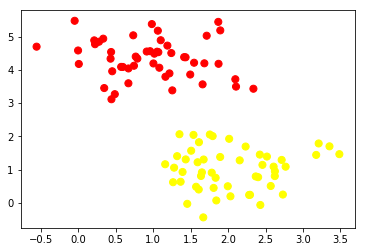

In [243]:
# A case of a simple classification task, in which the two classes of points are well separated:

from sklearn.datasets.samples_generator import make_blobs
X1, y1 = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn');

In [244]:
#Using Linear Kernel (source: https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/)
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train_scaled, y_train) 
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [245]:
#To make predictions, the predict method of the SVC class is used. 
y_pred = svclassifier.predict(X_test_scaled)

In [246]:
#Confusion matrix, precision, recall, and F1 measures are the most commonly used metrics for classification tasks. 
#Scikit-Learn's metrics library contains the classification_report and confusion_matrix methods, which can be readily used to find out the values for these important metrics.
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[1292  318]
 [ 774  558]]
             precision    recall  f1-score   support

          0       0.63      0.80      0.70      1610
          1       0.64      0.42      0.51      1332

avg / total       0.63      0.63      0.61      2942



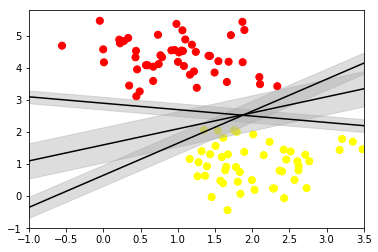

In [247]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='autumn');

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

In [248]:
# SVMs on the data, Running the rbf model with scaled data to improve the accuracy 
from sklearn.svm import SVC

# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.6478585995921142
[[1228  382]
 [ 654  678]]


In [249]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )
print(svm_clf.support_)

(9227, 73)
(9227,)
[4737 4490]
[    3     7    10 ... 11756 11757 11759]


## Model Discussion

## Logistic Regression Weight Interpretation

From the weights below, you can easily tell the direction of the relationship each dependent variable had. A negative value suggests that, if variable is true or increases, the likely hood of an on time arrival would increase as well. We can also can tell the magnitude of the effect by how far each weight is from zero. 

Since the categorical attributes were all broken out into binary variables, we have a lot of weights to look at. With binary variables it is much easier to compare the magnitude of their effect. We do not have to scale them for comparison. If you refer to the “weight Magnitude” Chart, we can easily see what variables have the largest impact. 

route_Local Street – Municipality has the highest weight of .729. That means if the accident is on a street down town, the likely hood of the repose being under the standard time goes up by .729% holding all other factors constant. 


Talk about parameters we can change to make model more acc

[[-7.01667466e-02 -1.85728936e-02 -5.82447497e-02 -4.96917441e-02
  -1.01616190e-02  7.85296207e-02  2.05870405e-01  1.48607438e-01
   2.78532752e-12  9.28790770e-02 -6.35924805e-02  1.44443612e-01
  -3.45201889e-02 -1.01555677e-02 -3.14713241e-02 -2.64936572e-02
  -6.24811124e-02 -5.81475171e-02 -2.92196664e-02 -6.65238570e-03
   1.40161317e-01 -5.39380089e-02 -4.39409083e-02 -3.76977454e-02
  -5.46404101e-02 -3.36923116e-02 -2.40515982e-02  1.87532161e-01
  -2.70405124e-02 -3.57441705e-02 -3.91826402e-02  3.51830547e-01
  -7.74363444e-02 -2.08173166e-02 -7.50670927e-02 -4.99611486e-02
  -4.53501430e-02  3.50551460e-01  9.54926167e-02 -2.71382388e-03
  -2.16588824e-02 -4.70204764e-02 -7.51045191e-02 -3.64411849e-02
  -1.75694367e-02 -1.71414975e-02 -4.69924916e-03 -2.52325683e-02
  -4.15435617e-02 -2.64919327e-02 -1.21006894e-01 -1.12960333e-01
  -2.67135604e-02  6.07001910e-01 -6.30362660e-02 -1.60872154e-01
  -1.32413044e-01 -8.34989246e-06  8.32151660e-07  4.83341466e-06
  -2.72992

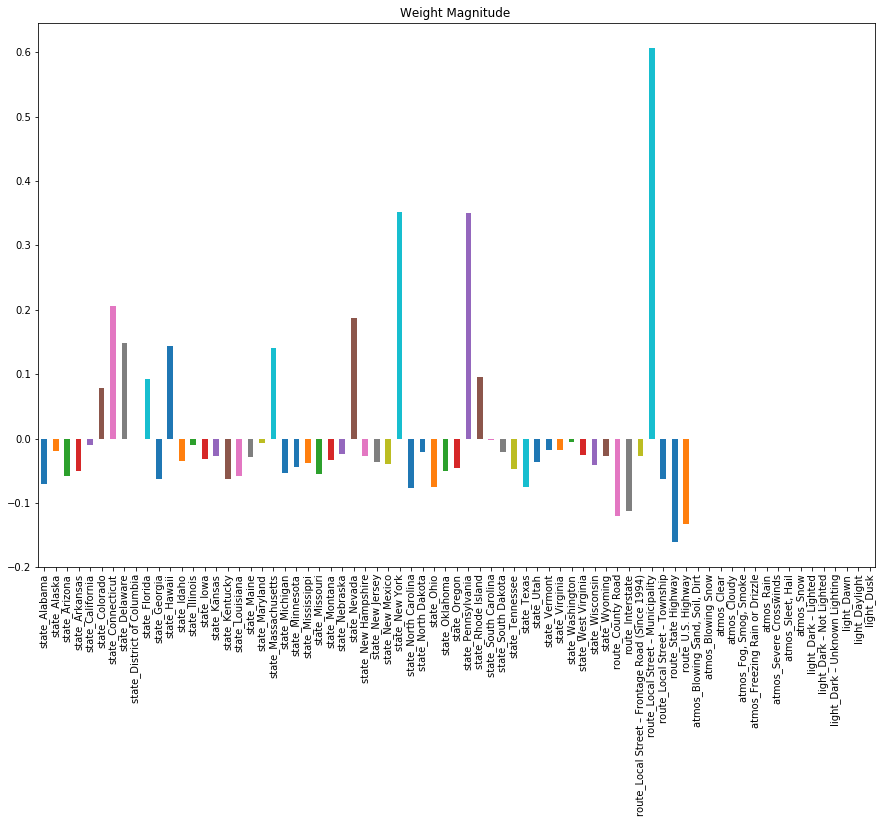

In [250]:
## using linear kernel to get the bar chart of coef weights
print(svclassifier.coef_)

weights = pd.Series(svclassifier.coef_[0],index=Accident_forLr_chart.columns)
weights.plot(kind='bar', figsize=(15, 10),title='Weight Magnitude ')


In [251]:
# Code addapted from the Dataming Notbooks. Logistic Regression Notbook 4.
#Generates weights from the LR model.


# iterate over the coefficients 
weights = OnTime_lr_clf.coef_.T # take transpose to make a column vector
variable_names = Accident_forLr.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    


state_Alabama has weight of -0.5120096959853613
state_Alaska has weight of -0.09549643760456925
state_Arizona has weight of 0.19755844500680747
state_Arkansas has weight of -0.49256786954215437
state_California has weight of 0.2713689139945049
state_Colorado has weight of 0.8144610097244689
state_Connecticut has weight of 0.665079832474564
state_Delaware has weight of 0.7871055722781798
state_District of Columbia has weight of 0.552890910797353
state_Florida has weight of 0.7618591877804735
state_Georgia has weight of 0.22877792675950337
state_Hawaii has weight of 0.18390417249588686
state_Idaho has weight of -0.0897914435494204
state_Illinois has weight of 0.6547415625387981
state_Iowa has weight of -0.2120312345901795
state_Kansas has weight of -0.7897453531154305
state_Kentucky has weight of 0.059393653694945855
state_Louisiana has weight of -0.3470821609724181
state_Maine has weight of -0.20179008250195682
state_Maryland has weight of -0.6215410581842001
state_Massachusetts has wei

In [252]:



df_tested_on = Accident_forLr.iloc[train_indices]
df_support = df_tested_on.iloc[svm_clf.support_,:]
svm_clf.support_df = pd.DataFrame(svm_clf.support_)
df_support['within 9 minutes NFPA standard'] = y[svm_clf.support_]# add back in the  Column to the pandas dataframe
Accident_forLr['within 9 minutes NFPA standard'] = y # also add it back in for the original data
df_support.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9227 entries, 14192 to 29146
Data columns (total 74 columns):
state_Alabama                                      9227 non-null uint8
state_Alaska                                       9227 non-null uint8
state_Arizona                                      9227 non-null uint8
state_Arkansas                                     9227 non-null uint8
state_California                                   9227 non-null uint8
state_Colorado                                     9227 non-null uint8
state_Connecticut                                  9227 non-null uint8
state_Delaware                                     9227 non-null uint8
state_District of Columbia                         9227 non-null uint8
state_Florida                                      9227 non-null uint8
state_Georgia                                      9227 non-null uint8
state_Hawaii                                       9227 non-null uint8
state_Idaho                         

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


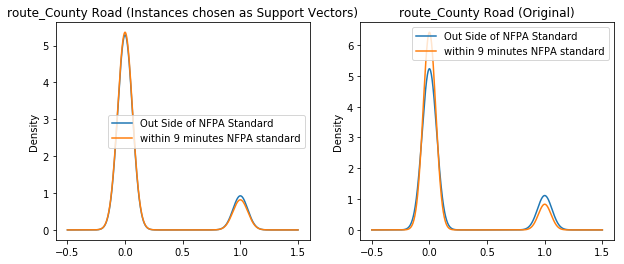

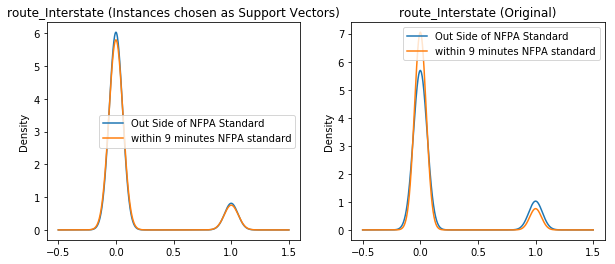

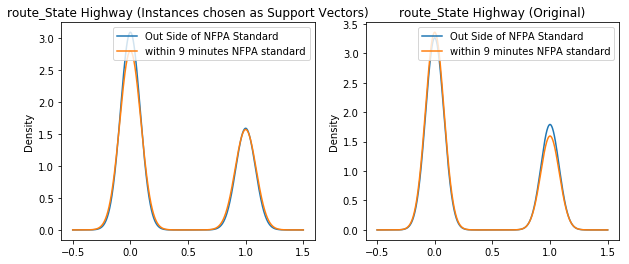

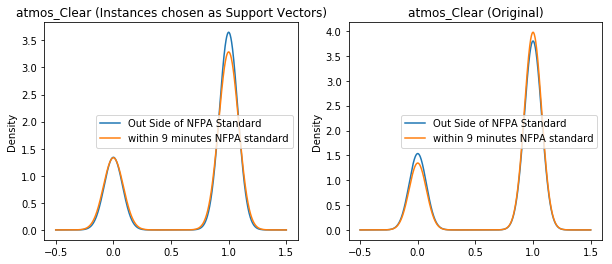

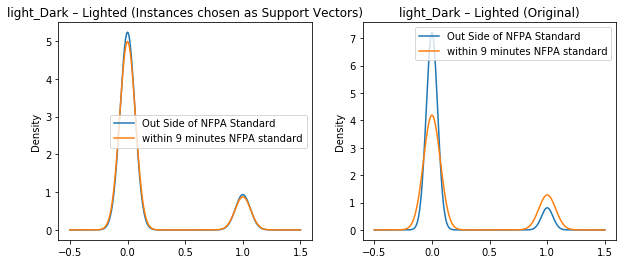

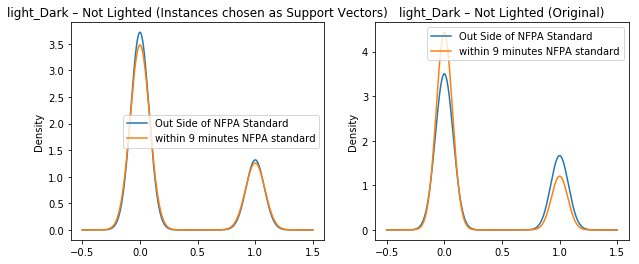

In [253]:

# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors

df_grouped_support = df_support.groupby(['within 9 minutes NFPA standard'])
df_grouped = Accident_forLr.groupby(['within 9 minutes NFPA standard'])

# plot KDE of Different variables
vars_to_plot = ['route_County Road','route_Interstate','route_State Highway','atmos_Clear','light_Dark – Lighted',
               'light_Dark – Not Lighted']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Out Side of NFPA Standard','within 9 minutes NFPA standard'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Out Side of NFPA Standard','within 9 minutes NFPA standard'])
    plt.title(v+' (Original)')

So the analysis here is basically telling us what the original statistics of the data looked like, and also what the statistics of the support vectors looked like. We can see that the separation in distributions is not as great as the separation for the original data. This is because the support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.


## Discuses in meeting 
Weights changed to negative 


In [254]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
OnTime_lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
OnTime_lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = OnTime_lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(OnTime_lr_clf.coef_.T,Accident_forLr.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shayden\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


accuracy: 0.6458191706322229
[[1245  365]
 [ 677  655]]
route_Interstate has weight of -0.1486978781994349
light_Dark – Not Lighted has weight of -0.14335077918486908
state_Wyoming has weight of -0.13277290046677254
state_Montana has weight of -0.13212925833407688
state_Alabama has weight of -0.12598905599140728
route_County Road has weight of -0.11563881086799037
state_Texas has weight of -0.10279115008031105
state_Missouri has weight of -0.10136587595166882
state_North Dakota has weight of -0.08856129348299553
state_West Virginia has weight of -0.0811167219793002
state_Arkansas has weight of -0.07995975307968248
state_Kansas has weight of -0.0693755499312588
state_Louisiana has weight of -0.064468102398123
state_New Hampshire has weight of -0.06350395215675335
state_Wisconsin has weight of -0.061081206779685024
state_South Dakota has weight of -0.06084354943162571
atmos_Snow has weight of -0.058012385866179524
route_State Highway has weight of -0.04976702363063529
atmos_Fog, Smog, Sm

## Insights based on the Classification Task

In [255]:

#traffic might suck more than living in the country??
